In [55]:
import tensorflow as tf
import tensorflow.keras as K
from tensorflow.keras import Model
from tensorflow.keras.losses import Loss
from tensorflow.keras.layers import Layer, Conv2D, Input, Flatten, Dense
import numpy as np
import matplotlib.pyplot as plt



In [56]:
class MaxPoolingWithArgmax2D(Layer):
    def __init__(
            self,
            pool_size=(2, 2),
            strides=(2, 2),
            padding='same',
            **kwargs):
        super(MaxPoolingWithArgmax2D, self).__init__(**kwargs)
        self.padding = padding
        self.pool_size = pool_size
        self.strides = strides

    def call(self, inputs, **kwargs):
        padding = self.padding
        pool_size = self.pool_size
        strides = self.strides
        ksize = [1, pool_size[0], pool_size[1], 1]
        strides = [1, strides[0], strides[1], 1]
        output, argmax = tf.nn.max_pool_with_argmax(inputs, ksize, strides, 'SAME')
        argmax = tf.cast(argmax, tf.keras.backend.floatx())
        return [output, argmax]

    def compute_output_shape(self, input_shape):
        ratio = (1, 2, 2, 1)
        output_shape = [
            dim // ratio[idx]
            if dim is not None else None
            for idx, dim in enumerate(input_shape)]
        output_shape = tuple(output_shape)
        return [output_shape, output_shape]

    def compute_mask(self, inputs, mask=None):
        return 2 * [None]


In [57]:
class MaxUnpooling2D(Layer):
    def __init__(self, up_size=(2, 2), **kwargs):
        super(MaxUnpooling2D, self).__init__(**kwargs)
        self.up_size = up_size
    
    def unpool(self, pool, ind, ksize=[1, 2, 2, 1]):
        input_shape = tf.shape(pool)
        output_shape = [input_shape[0], input_shape[1] * ksize[1], input_shape[2] * ksize[2], input_shape[3]]

        flat_input_size = tf.math.reduce_prod(input_shape)
        flat_output_shape = [output_shape[0], output_shape[1] * output_shape[2] * output_shape[3]]

        pool_ = tf.reshape(pool, [flat_input_size])
        batch_range = tf.reshape(tf.range(tf.cast(output_shape[0], tf.int64), dtype=ind.dtype),
                                          shape=[input_shape[0], 1, 1, 1])
        b = tf.ones_like(ind) * batch_range
        b1 = tf.reshape(b, [flat_input_size, 1])
        ind_ = tf.reshape(ind, [flat_input_size, 1])
        ind_ = tf.concat([b1, ind_], 1)

        ret = tf.scatter_nd(ind_, pool_, shape=tf.cast(flat_output_shape, tf.int64))
        ret = tf.reshape(ret, output_shape)

        set_input_shape = pool.get_shape()
        set_output_shape = [set_input_shape[0], set_input_shape[1] * ksize[1], set_input_shape[2] * ksize[2], set_input_shape[3]]
        ret.set_shape(set_output_shape)
        return ret

    def call(self, inputs, output_shape=None):
        updates = inputs[0]
        mask    = tf.cast(inputs[1], dtype=tf.int64)
        ksize   = [1, self.up_size[0], self.up_size[1], 1]
        return self.unpool(updates, mask, ksize)

    def compute_output_shape(self, input_shape):
        mask_shape = input_shape[1]
        return (
            mask_shape[0],
            mask_shape[1] * self.up_size[0],
            mask_shape[2] * self.up_size[1],
            mask_shape[3]
        )

In [58]:
class Encoder(Model):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.conv1 = Conv2D(16, (5, 5), activation='relu', padding='same')
        self.conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')
        self.max_pool_argmax = MaxPoolingWithArgmax2D(pool_size=(7,7), strides=(7,7))
        self.dense1 = Dense(latent_dim, activation='relu', bias_initializer='ones')
        self.flatten = Flatten()
        
    def sample(self, alpha_hat):
        shape = (alpha_hat.get_shape().as_list()[-2],alpha_hat.get_shape().as_list()[-1])
        u = tf.random.uniform(shape=shape, minval=0, maxval=1)
        v = tf.math.multiply(u,alpha_hat)
        v = tf.math.multiply(v, tf.math.exp(tf.math.lgamma(alpha_hat)))
        v = tf.math.pow(v, tf.math.divide(1.0,alpha_hat))
        #no beta because vector of all ones
        z = tf.math.divide(v,tf.math.reduce_sum(v)) #sum to one
        return z
    
    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x, mask_1 = self.max_pool_argmax(x)
        L2M_encoder_1 = x
        alpha_hat = self.flatten(x)
        alpha_hat_shape = alpha_hat.shape
        alpha_hat = self.dense1(alpha_hat)
        z = self.sample(alpha_hat)
        return z, mask_1, L2M_encoder_1, alpha_hat, alpha_hat_shape

In [59]:
class Decoder(Model):
    def __init__(self, original_shape):
        super(Decoder, self).__init__()
        self.unpool_1 = MaxUnpooling2D((7,7))
        self.conv_1 = Conv2D(16, (3, 3), activation='relu', padding='same')
        self.conv_2 = Conv2D(1, (5, 5), activation='sigmoid', padding='same')
        

    def call(self, x):
        x[0] = Dense(x[2][1])(x[0])
        x[0] = tf.reshape(x[0],x[3])
        L2M_decoder_1 = x[0]
        x = self.unpool_1([x[0],x[1]])
        x = self.conv_1(x)
        x = self.conv_2(x)
        return x, L2M_decoder_1

In [60]:
class betaSWWDirVAE(Model):
    def __init__(self, input_dim):
        super(betaSWWDirVAE, self).__init__()
        self.encoder = Encoder(input_dim)
        self.decoder = Decoder(input_dim)
    
    def compile(self, optimizer, loss):
        super().compile(optimizer)
        self.loss = loss

    def call(self, x):
        # Forward pass through the encoder and decoder
        encoded, mask_1, L2M_encoder_1, alpha_hat, alpha_hat_shape = self.encoder(x)
        decoded, L2M_decoder_1 = self.decoder([encoded, mask_1, alpha_hat_shape, L2M_encoder_1.shape])
        return decoded, L2M_encoder_1, L2M_decoder_1, alpha_hat

In [61]:
def ELBO(mse, log_likelihood, y_true, y_pred, L2M_encoder_1, L2M_decoder_1, alpha_hat, alpha):
    ll_loss = log_likelihood(y_true, y_pred)
    
    mse_loss = mse(y_true, y_pred)
    
    l2m_loss = tf.math.reduce_mean(tf.math.square(tf.math.subtract(L2M_encoder_1,L2M_decoder_1)))
    
    kld_loss = tf.math.subtract(tf.math.lgamma(alpha), tf.math.lgamma(alpha_hat))
    kld_loss = tf.math.add(kld_loss, tf.math.multiply(tf.math.subtract(alpha_hat, alpha),tf.math.digamma(alpha_hat)))
    kld_loss = tf.reduce_sum(kld_loss)
    
    total_loss = ll_loss + 0.2*l2m_loss + kld_loss
    
    return total_loss, mse_loss, ll_loss, l2m_loss, kld_loss

In [62]:
def ClipIfNotNone(grad):
            if grad is None:
                return grad
            return tf.clip_by_value(grad, -1, 1)

___________________________
_____EPOCH_0________
___________________________
Training loss at step 0: 105.2372
mse loss at step 0: 0.2317
LL loss at step 0: 0.6931
kld loss at step 0: 104.5419
l2m loss at step 0: 0.0107

Training loss at step 250: 1.2425
mse loss at step 250: 0.1794
LL loss at step 250: 0.5886
kld loss at step 250: 0.6538
l2m loss at step 250: 0.0003

AVERAGE VALIDATION LOSS: 0.546981

ORIGINAL


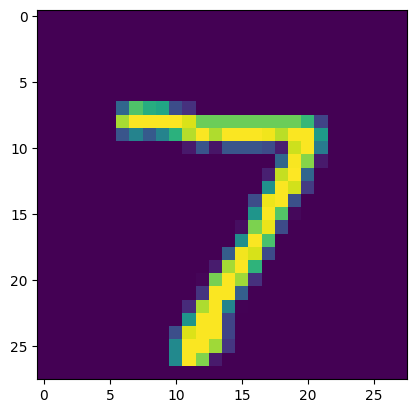


RECONSTRUCTION


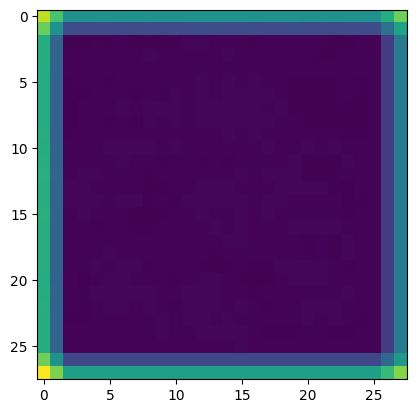


___________________________
_____EPOCH_1________
___________________________
Training loss at step 0: 0.5416
mse loss at step 0: 0.1211
LL loss at step 0: 0.4612
kld loss at step 0: 0.0804
l2m loss at step 0: 0.0000

Training loss at step 250: 0.4318
mse loss at step 250: 0.1060
LL loss at step 250: 0.4224
kld loss at step 250: 0.0095
l2m loss at step 250: 0.0000



KeyboardInterrupt: 

In [63]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train.astype('float32') / 255., -1)
x_test = np.expand_dims(x_test.astype('float32') / 255., -1)

latent_dim = 50
model = betaSWWDirVAE(latent_dim)

optimizer = tf.optimizers.Adam(learning_rate=1e-4)
log_likelihood = tf.keras.losses.BinaryCrossentropy()
mse = tf.keras.losses.MeanSquaredError()
alpha = (1 - 1/latent_dim) * tf.ones(shape=(latent_dim,))

batch_size = 128
train_dataset = tf.data.Dataset.from_tensor_slices((x_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test))
test_dataset = test_dataset.shuffle(buffer_size=1024).batch(batch_size)

epochs = 10
for epoch in range(epochs):
    print('___________________________')
    print(f'_____EPOCH_{epoch}________')
    print('___________________________')

    # Iterate over the batches of the dataset.
    for step, (x_batch_train) in enumerate(train_dataset):
        # Open a GradientTape to record the operations run
        # during the forward pass, which enables auto-differentiation.
        with tf.GradientTape() as tape:
            prediction, L2M_encoder_1, L2M_decoder_1, alpha_hat = model(x_batch_train, training=True)
            # Compute the loss value for this minibatch.
            total_loss, mse_loss, ll_loss, l2m_loss, kld_loss = ELBO(mse, log_likelihood, x_batch_train, prediction, L2M_encoder_1, L2M_decoder_1, alpha_hat, alpha)

        # Use the gradient tape to automatically retrieve
        # the gradients of the trainable variables with respect to the loss.
        grads = tape.gradient(total_loss, model.trainable_weights)
        grads = [ClipIfNotNone(grad) for grad in grads]
        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        # Log every 250 batches.
        if step % 250 == 0:
            print(f"Training loss at step {step}: {float(total_loss):.4f}")
            print(f"mse loss at step {step}: {float(mse_loss):.4f}")
            print(f"LL loss at step {step}: {float(ll_loss):.4f}")
            print(f"kld loss at step {step}: {float(kld_loss):.4f}")
            print(f"l2m loss at step {step}: {float(l2m_loss):.4f}\n")
            
    val_loss = []
    for step, (x_batch_test) in enumerate(test_dataset):
        val_prediction, val_L2M_encoder_1, val_L2M_decoder_1, val_alpha_hat = model(x_batch_test, training=False)
        val_total_loss, vale_mse_loss, val_ll_loss, val_l2m_loss, val_kld_loss = ELBO(mse, log_likelihood, x_batch_test, val_prediction, val_L2M_encoder_1, val_L2M_decoder_1, val_alpha_hat, alpha)
        val_loss.append(val_total_loss.numpy())
    val_loss = np.mean(np.array(val_loss))
    print('AVERAGE VALIDATION LOSS:', val_loss)
    print()
    image, img_L2M_encoder_1, img_L2M_decoder_1, img_alpha_hat = model(x_test[0].reshape((1,28,28,1)), training=False)
    print('ORIGINAL')
    plt.imshow(x_test[0].reshape((28,28)))
    plt.show()
    print()
    print('RECONSTRUCTION')
    plt.imshow(tf.reshape(image, (28,28)).numpy())
    plt.show()
    print()

In [ ]:
model.summary()

In [ ]:
x_recon = model.predict(x_test[:25])
x_plot = np.concatenate((x_test[:25], x_recon[0]), axis=1)
print(x_plot.shape)
x_plot = x_plot.reshape((28,1,10,56))
x_plot = np.vstack([np.hstack(x) for x in x_plot])
plt.figure()
plt.axis('off')
plt.title('Test Samples: Originals/Reconstructions')
plt.imshow(x_plot, interpolation='none', cmap='gray')
plt.savefig('reconstructions.png')